In [10]:
import json
import os
import torch.nn.functional as F
import numpy as np
import torch
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models.segmentation.deeplabv3 import deeplabv3_resnet50, deeplabv3_resnet101
 
# Define the COCO_CLASSES and COCO_LABEL_MAP
COCO_CLASSES = ('__background__','break', 'thunderbolt', "0", "Inclusoes", "Rechupe", "Collision", "Dirty",
               "Gap", "Scratch", "Chip", "PistonMiss", "Porosity", "RCS", "damage", "s_burr", "s_scratch",
               "Defect-A", "Defect-B", "Defect-C", "Defect-D", "Fiber", "Flash Particle", "Hole", "Surface Damage",
               "Tear", "missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper",
               "defect1", "defect2", "defect3", "defect4", "defect5", "defect6", "defect7", "t_contamination",
               "t_scratch", "unfinished_surface", "defect", "impurities", "pits")
 
COCO_LABEL_MAP = {cls: idx for (idx, cls) in enumerate(COCO_CLASSES)}
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
 
 
# Define custom dataset
class VISIONDataset(Dataset):
    def __init__(self, root_dir, split="train", annotation_file='_annotations.coco.json'):
        self.root_dir = root_dir
        self.img_dir = os.path.join(self.root_dir, split)
        self.annotation_file = os.path.join(self.root_dir, split, annotation_file)
        self.annotations = self._load_annotations()
 
        # Collect all image file names
        self.img_files = sorted([f for f in os.listdir(self.img_dir)
                                 if f.endswith('.jpg') and not f.startswith('._')])
 
    def _load_annotations(self):
        with open(self.annotation_file, 'r') as f:
            return json.load(f)
 
    def _get_annotation_for_image(self, image_id):
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == image_id]
        return annotations
    
    def _get_image_id_by_name(self, file_name):
        for image in self.annotations['images']:
            if image['file_name'] == file_name:
                return image['id']
        return None  # Return None if no match is found
 
    def __len__(self):
        return len(self.img_files)
 
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
       
        # Load image
        orig_image = Image.open(img_path).convert('RGB')
 
        # Find corresponding image ID by file name
        image_id = self._get_image_id_by_name(img_name)
 
        # Find corresponding annotations
        image_annotations = self._get_annotation_for_image(image_id)
 
        # Create mask
        mask = Image.new('L', orig_image.size, 0)  # Initialize with 0s for background
        draw = ImageDraw.Draw(mask)
        for annotation in image_annotations:
            class_id = annotation['category_id']
            if class_id in COCO_LABEL_MAP.values():
                segmentation = annotation['segmentation']
                if isinstance(segmentation[0], list):
                    points = [tuple(point) for segment in segmentation for point in zip(segment[::2], segment[1::2])]
                    draw.polygon(points, fill=class_id + 1)
        mask = np.array(mask)
 
        # Define the transformations including resizing to 550x550
        transform = transforms.Compose([
            transforms.Resize((550, 550)), 
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
       
        img = transform(orig_image)
 
        mask = Image.fromarray(mask).resize((550, 550), resample=Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.int64)
 
        return img, mask
 
    @staticmethod
    def visualize_mask(mask):
        fig, ax = plt.subplots(1)
        ax.imshow(mask, cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()
 
 
def custom_collate(batch):
    images, masks = [], []
    for sample in batch:
        img, mask = sample
        if isinstance(img, torch.Tensor):
            images.append(img)
        else:
            img = transforms.ToTensor()(img)
            images.append(img)
        masks.append(mask)
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    return images, masks
 
 
def dice_loss(pred, target):
    smooth = 1.
    num_classes = pred.size(1)
    loss = 0.
    for c in range(num_classes):
        p = pred[:, c]
        t = target == c
        intersection = (p * t).sum()
        loss += (2. * intersection + smooth) / (p.sum() + t.sum() + smooth)
    return 1. - loss / num_classes
 
 
def jaccard_index_loss(logits, targets):
    # apply softmax to logits along the channel dimension
    probs = F.softmax(logits, dim=1)
    # get the predicted class masks from the probabilities
    pred_masks = probs.argmax(dim=1)
    # compute intersection and union between predicted and ground truth masks
    intersection = (pred_masks & targets).float().sum(dim=(1, 2))
    union = (pred_masks | targets).float().sum(dim=(1, 2))
    # compute Jaccard index and return the loss
    jaccard = intersection / union
    return (1 - jaccard).mean()
 
 
if __name__ == '__main__':
    # Initialization
    num_epochs = 5
    batch_size = 8

    # Initialize custom dataset and data loader
    root_dir = '/kaggle/input/dataset-new/data'  # Change this to your dataset root directory
    train_dataset = VISIONDataset(root_dir=root_dir, split='train')
    val_dataset = VISIONDataset(root_dir=root_dir, split='val')

    # Initialize dataloaders for both training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate,
                              drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate,
                            drop_last=True)

    # Initialize model and optimizer
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device: ', device)
    # Move model and data to GPU
    model = deeplabv3_resnet50(pretrained=False, num_classes=len(COCO_CLASSES))
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print('Training started...')

    # Initialize history to store loss values
    train_loss_history = []
    val_loss_history = []

    # Training loop with validation phase
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_train_loss = 0.0
        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = torch.nn.functional.cross_entropy(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            print(
                f'Train Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate average train loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_loss_history.append(epoch_train_loss)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            epoch_val_loss = 0.0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)['out']
                val_loss = torch.nn.functional.cross_entropy(outputs, masks)
                epoch_val_loss += val_loss.item()
            epoch_val_loss /= len(val_loader)
            val_loss_history.append(epoch_val_loss)
            print(f'Validation Loss after Epoch {epoch + 1}: {epoch_val_loss:.4f}')

    print('Saving model...')
    # Save the model checkpoint as pth file
    model_path = 'model.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

    # Save train and validation loss history
    with open('train_loss_history.txt', 'w') as f:
        for loss in train_loss_history:
            f.write(f'{loss}\n')

    with open('val_loss_history.txt', 'w') as f:
        for loss in val_loss_history:
            f.write(f'{loss}\n')


Device:  cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


Training started...
Train Epoch [1/5], Step [1/165], Loss: 4.0543
Train Epoch [1/5], Step [2/165], Loss: 3.8269
Train Epoch [1/5], Step [3/165], Loss: 3.5321
Train Epoch [1/5], Step [4/165], Loss: 3.1780
Train Epoch [1/5], Step [5/165], Loss: 2.7532
Train Epoch [1/5], Step [6/165], Loss: 2.4442
Train Epoch [1/5], Step [7/165], Loss: 2.2216
Train Epoch [1/5], Step [8/165], Loss: 2.1032
Train Epoch [1/5], Step [9/165], Loss: 2.1541
Train Epoch [1/5], Step [10/165], Loss: 1.9508
Train Epoch [1/5], Step [11/165], Loss: 1.7063
Train Epoch [1/5], Step [12/165], Loss: 1.5487
Train Epoch [1/5], Step [13/165], Loss: 1.4168
Train Epoch [1/5], Step [14/165], Loss: 1.3423
Train Epoch [1/5], Step [15/165], Loss: 1.2357
Train Epoch [1/5], Step [16/165], Loss: 0.9531
Train Epoch [1/5], Step [17/165], Loss: 0.9099
Train Epoch [1/5], Step [18/165], Loss: 0.8916
Train Epoch [1/5], Step [19/165], Loss: 0.8822
Train Epoch [1/5], Step [20/165], Loss: 0.6941
Train Epoch [1/5], Step [21/165], Loss: 0.6053
Tr

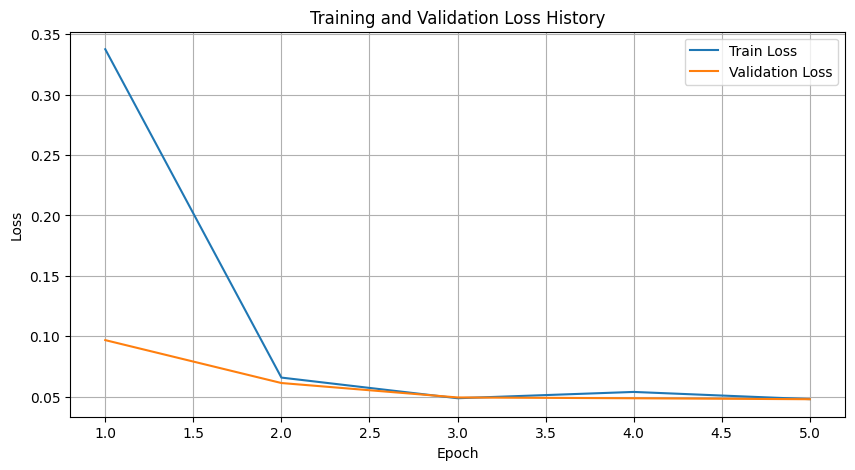

In [11]:
import matplotlib.pyplot as plt

# Load train and validation loss history from files
train_loss_history = []
val_loss_history = []

with open('train_loss_history.txt', 'r') as f:
    train_loss_history = [float(line.strip()) for line in f.readlines()]

with open('val_loss_history.txt', 'r') as f:
    val_loss_history = [float(line.strip()) for line in f.readlines()]

# Plot train and validation loss history
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
test_dataset = VISIONDataset(root_dir="/kaggle/input/dataset-new/data", split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
model.eval()
test_loss = 0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = F.cross_entropy(outputs, masks)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.0413


In [ ]:
# def visualize_prediction(image, mask, prediction):
#     fig, axes = plt.subplots(1, 3, figsize=(20, 5))
#     axes[0].imshow(image.cpu().permute(1, 2, 0))
#     axes[0].set_title('Original Image')
#     axes[1].imshow(mask.cpu(), cmap='gray')
#     axes[1].set_title('True Mask')
#     axes[2].imshow(prediction.cpu(), cmap='gray')
#     axes[2].set_title('Predicted Mask')
#     plt.show()

# # Lấy một batch từ tập kiểm tra
# images, masks = next(iter(test_loader))
# images, masks = images.to(device), masks.to(device)
# with torch.no_grad():
#     model.eval()
#     outputs = model(images)['out']
#     predictions = outputs.argmax(dim=1)

# # Visualize kết quả cho một vài mẫu trong batch
# for i in range(batch_size):
#     visualize_prediction(images[i], masks[i], predictions[i])


In [12]:
# Assume the model is already defined as `model` and we are just loading weights
model_path = 'model.pth'  # Path to your saved model
model = deeplabv3_resnet50(pretrained=False, num_classes=len(COCO_CLASSES))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [14]:
test_dataset = VISIONDataset(root_dir='/kaggle/input/dataset-new/data', split='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate)


In [19]:


# Accuracy
def accuracy(preds, labels):
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc

# Intersection over Union (IoU)
def iou(preds, labels, num_classes):
    ious = []
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())
    return np.nanmean(ious)

# Test and compute metrics
def test_model(test_loader, model, device):
    model.eval()
    accuracies = []
    iou_scores = []
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)['out']
            preds = outputs.argmax(dim=1)
        accuracies.append(accuracy(preds, masks).item())
        iou_scores.append(iou(outputs, masks, len(COCO_CLASSES)))

    print(f'Mean Accuracy: {np.mean(accuracies)}')
    print(f'Mean IoU: {np.mean(iou_scores)}')

test_model(test_loader, model, device)


Mean Accuracy: 0.9939219355583191
Mean IoU: 0.2211936821214973


In [20]:
def classwise_iou(preds, labels, num_classes):
    ious = []
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        iou = (intersection / union).item() if union != 0 else float('nan')
        ious.append(iou)
    return ious

# Adjust the test_model function to include class-wise IoU:
def test_model(test_loader, model, device):
    model.eval()
    accuracies = []
    ious = []
    classwise_ious = {i: [] for i in range(len(COCO_CLASSES))}  # Prepare a dictionary to store class-wise IoUs

    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)['out']
            preds = outputs.argmax(dim=1)
        accuracies.append(accuracy(preds, masks).item())
        iou_scores = classwise_iou(outputs, masks, len(COCO_CLASSES))
        for cls in range(len(COCO_CLASSES)):
            if not np.isnan(iou_scores[cls]):
                classwise_ious[cls].append(iou_scores[cls])

    print(f'Mean Accuracy: {np.mean(accuracies)}')
    print(f'Mean IoU: {np.nanmean([np.nanmean(i) for i in classwise_ious.values()])}')
    for cls in range(len(COCO_CLASSES)):
        if classwise_ious[cls]:
            print(f'Class {COCO_CLASSES[cls]} IoU: {np.nanmean(classwise_ious[cls]):.4f}')

test_model(test_loader, model, device)


Mean Accuracy: 0.9939219355583191
Mean IoU: 0.03695883218086127
Class __background__ IoU: 0.9938
Class break IoU: 0.0000
Class thunderbolt IoU: 0.0000
Class 0 IoU: 0.0000
Class Inclusoes IoU: 0.0000
Class Rechupe IoU: 0.0000
Class Collision IoU: 0.0000
Class Dirty IoU: 0.0000
Class Gap IoU: 0.0000
Class Scratch IoU: 0.0000
Class Chip IoU: 0.0000
Class PistonMiss IoU: 0.6324
Class Porosity IoU: 0.0000
Class RCS IoU: 0.0000
Class damage IoU: 0.0000
Class s_burr IoU: 0.0000
Class s_scratch IoU: 0.0000
Class Defect-A IoU: 0.0000
Class Defect-B IoU: 0.0000
Class Defect-C IoU: 0.0000
Class Defect-D IoU: 0.0000
Class Fiber IoU: 0.0000
Class Flash Particle IoU: 0.0000
Class Hole IoU: 0.0000
Class Surface Damage IoU: 0.0000
Class Tear IoU: 0.0000
Class missing_hole IoU: 0.0000
Class mouse_bite IoU: 0.0000
Class open_circuit IoU: 0.0000
Class short IoU: 0.0000
Class spur IoU: 0.0000
Class spurious_copper IoU: 0.0000
Class defect1 IoU: 0.0000
Class defect2 IoU: 0.0000
Class defect3 IoU: 0.0000
Cl

/tmp/ipykernel_34/3299463142.py:32: RuntimeWarning: Mean of empty slice
  print(f'Mean IoU: {np.nanmean([np.nanmean(i) for i in classwise_ious.values()])}')


In [16]:
def test_model(test_loader, model, device):
    model.eval()
    total_correct = 0
    total_elements = 0
    
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)['out']
            preds = outputs.argmax(dim=1)
            correct = (preds == masks).float().sum()
            total_correct += correct
            total_elements += masks.numel()  # Total number of elements in the mask

    mean_accuracy = total_correct / total_elements
    print(f'Mean Accuracy: {mean_accuracy.item()}')

test_model(test_loader, model, device)

Mean Accuracy: 0.9940900206565857


In [26]:
import json
import os
import torch.nn.functional as F
import numpy as np
import torch
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models.segmentation.deeplabv3 import deeplabv3_resnet50, deeplabv3_resnet101
 
# Define the COCO_CLASSES and COCO_LABEL_MAP
COCO_CLASSES = ('__background__','break', 'thunderbolt', "0", "Inclusoes", "Rechupe", "Collision", "Dirty",
               "Gap", "Scratch", "Chip", "PistonMiss", "Porosity", "RCS", "damage", "s_burr", "s_scratch",
               "Defect-A", "Defect-B", "Defect-C", "Defect-D", "Fiber", "Flash Particle", "Hole", "Surface Damage",
               "Tear", "missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper",
               "defect1", "defect2", "defect3", "defect4", "defect5", "defect6", "defect7", "t_contamination",
               "t_scratch", "unfinished_surface", "defect", "impurities", "pits")
 
COCO_LABEL_MAP = {cls: idx for (idx, cls) in enumerate(COCO_CLASSES)}
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
 
 
# Define custom dataset
class VISIONDataset(Dataset):
    def __init__(self, root_dir, split="train", annotation_file='_annotations.coco.json'):
        self.root_dir = root_dir
        self.img_dir = os.path.join(self.root_dir, split)
        self.annotation_file = os.path.join(self.root_dir, split, annotation_file)
        self.annotations = self._load_annotations()
 
        # Collect all image file names
        self.img_files = sorted([f for f in os.listdir(self.img_dir)
                                 if f.endswith('.jpg') and not f.startswith('._')])
 
    def _load_annotations(self):
        with open(self.annotation_file, 'r') as f:
            return json.load(f)
 
    def _get_annotation_for_image(self, image_id):
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == image_id]
        return annotations
    
    def _get_image_id_by_name(self, file_name):
        for image in self.annotations['images']:
            if image['file_name'] == file_name:
                return image['id']
        return None  # Return None if no match is found
 
    def __len__(self):
        return len(self.img_files)
 
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
       
        # Load image
        orig_image = Image.open(img_path).convert('RGB')
 
        # Find corresponding image ID by file name
        image_id = self._get_image_id_by_name(img_name)
 
        # Find corresponding annotations
        image_annotations = self._get_annotation_for_image(image_id)
        print(image_annotations)
        # Create mask
        mask = Image.new('L', orig_image.size, 0)  # Initialize with 0s for background
        draw = ImageDraw.Draw(mask)
        for annotation in image_annotations:
            class_id = annotation['category_id']
            if class_id in COCO_LABEL_MAP.values():
                segmentation = annotation['segmentation']
                print(class_id)
                if isinstance(segmentation[0], list):
                    points = [tuple(point) for segment in segmentation for point in zip(segment[::2], segment[1::2])]
                    draw.polygon(points, fill=class_id + 1)
        mask = np.array(mask)
 
        # Define the transformations including resizing to 550x550
        transform = transforms.Compose([
            transforms.Resize((550, 550)),  # Resize both image and mask to 550x550
            transforms.ToTensor()
        ])
       
        img = transform(orig_image)
 
        mask = Image.fromarray(mask).resize((640, 640), resample=Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.int64)
        self.visualize_mask(mask)
        return img, mask
 
    @staticmethod
    def visualize_mask(mask):
        fig, ax = plt.subplots(1)
        ax.imshow(mask, cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()
 
    @staticmethod
    def visualize_mask(mask):
        fig, ax = plt.subplots(1)
        ax.imshow(mask, cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()

In [27]:
def visualize_sample(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img.permute(1, 2, 0))  # Chuyển channel về cuối để phù hợp với yêu cầu của matplotlib
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Tắt các trục

    ax[1].imshow(mask, cmap='gray')  # Hiển thị mask
    ax[1].set_title('Mask')
    ax[1].axis('off')  # Tắt các trục

    
    plt.show()

# Giả sử bạn đã khởi tạo tập dữ liệu và DataLoader của bạn
root_dir = '/kaggle/input/dataset-new/data'  # Thay đổi theo đường dẫn thực tế của bạn
dataset = VISIONDataset(root_dir=root_dir, split='test')


[{'iscrowd': 0, 'image_id': 1022, 'bbox': [314, 71, 24, 21], 'segmentation': [[320, 71, 319, 72, 318, 72, 317, 73, 317, 74, 316, 75, 316, 76, 315, 77, 315, 80, 314, 81, 314, 82, 319, 87, 319, 88, 321, 90, 322, 90, 323, 91, 327, 91, 328, 92, 333, 92, 335, 90, 336, 90, 338, 88, 338, 83, 337, 82, 337, 79, 335, 77, 334, 77, 332, 75, 327, 75, 326, 74, 325, 74, 324, 73, 324, 72, 323, 71]], 'category_id': 2, 'id': 2154, 'area': 350}]
2


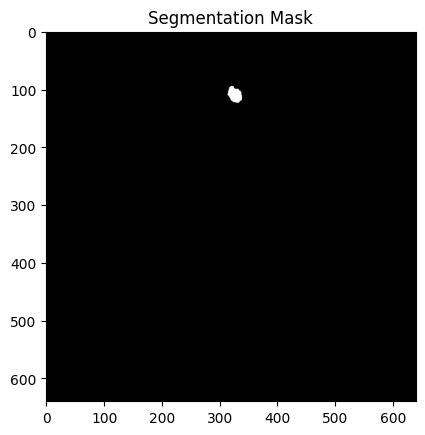

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
 

In [28]:
dataset.__getitem__(5)

[{'iscrowd': 0, 'image_id': 10, 'bbox': [29, 122, 579, 452], 'segmentation': [[369, 574, 333, 562, 311, 566, 275, 552, 149, 496, 129, 486, 117, 472, 134, 468, 150, 470, 165, 476, 186, 490, 320, 544, 368, 560, 370, 562], [462, 522, 435, 514, 219, 402, 214, 401, 264, 435, 307, 458, 325, 474, 300, 478, 276, 471, 219, 440, 165, 418, 86, 367, 46, 332, 29, 315, 30, 298, 40, 286, 143, 357, 153, 362, 160, 362, 103, 322, 62, 284, 57, 269, 66, 256, 82, 260, 106, 260, 99, 245, 107, 234, 135, 232, 159, 243, 165, 228, 191, 232, 208, 232, 184, 214, 182, 192, 188, 178, 167, 164, 156, 151, 165, 138, 193, 150, 215, 150, 227, 154, 239, 152, 246, 146, 246, 134, 253, 124, 262, 132, 273, 134, 280, 124, 318, 132, 339, 122, 345, 122, 383, 128, 462, 156, 510, 190, 524, 202, 536, 215, 536, 227, 495, 218, 434, 186, 391, 169, 411, 190, 437, 200, 455, 214, 474, 222, 493, 238, 507, 246, 525, 264, 558, 282, 588, 308, 605, 318, 608, 334, 607, 338, 513, 292, 509, 293, 533, 310, 553, 333, 533, 333, 477, 322, 544, 357,

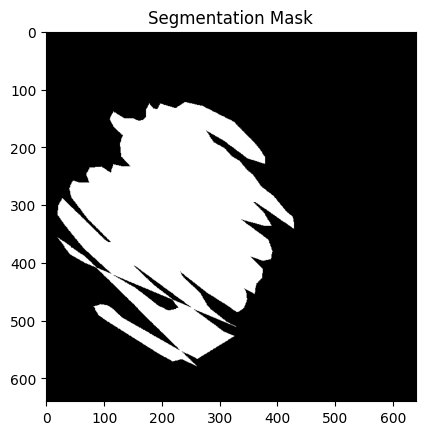

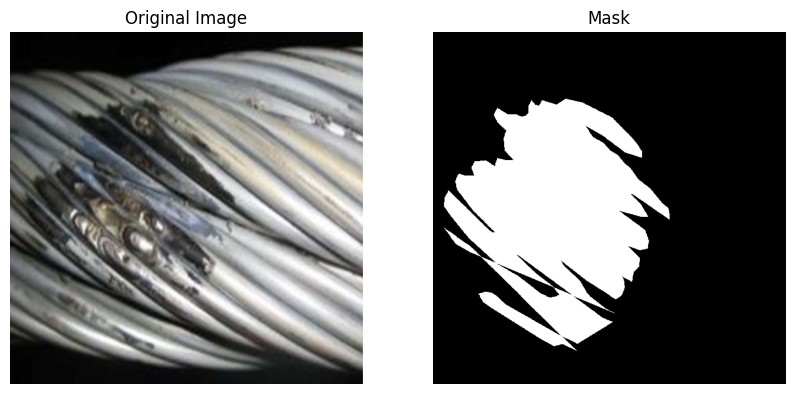

[{'iscrowd': 0, 'image_id': 100, 'bbox': [1855, 636, 66, 53], 'segmentation': [[1874, 636, 1872, 638, 1872, 639, 1867, 644, 1867, 645, 1866, 646, 1866, 648, 1865, 649, 1865, 655, 1864, 656, 1864, 657, 1863, 658, 1863, 661, 1862, 662, 1861, 661, 1859, 661, 1858, 662, 1858, 663, 1857, 664, 1857, 666, 1856, 667, 1856, 668, 1855, 669, 1855, 673, 1856, 674, 1856, 677, 1857, 678, 1857, 682, 1859, 684, 1860, 684, 1864, 688, 1877, 688, 1878, 689, 1886, 689, 1887, 688, 1890, 688, 1891, 689, 1893, 689, 1894, 688, 1896, 688, 1897, 687, 1900, 687, 1901, 686, 1901, 684, 1902, 683, 1907, 683, 1908, 682, 1909, 682, 1912, 679, 1912, 677, 1917, 672, 1918, 672, 1921, 669, 1921, 663, 1920, 662, 1920, 661, 1921, 660, 1921, 659, 1916, 654, 1916, 653, 1917, 652, 1918, 652, 1919, 651, 1919, 647, 1916, 644, 1915, 644, 1914, 645, 1909, 645, 1908, 646, 1902, 646, 1895, 639, 1891, 639, 1888, 636]], 'category_id': 4, 'id': 127, 'area': 2605}]
4


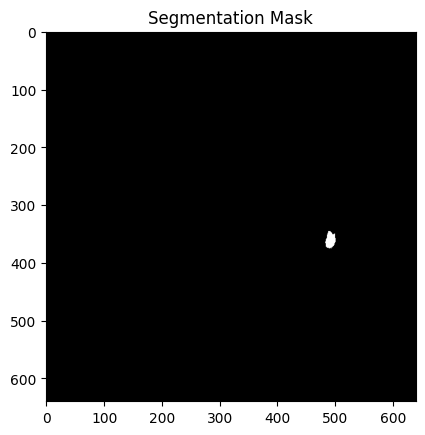

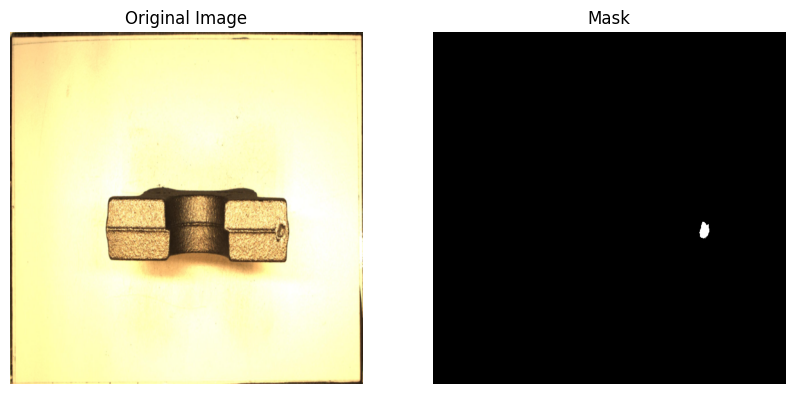

[{'iscrowd': 0, 'image_id': 1002, 'bbox': [1462, 0, 122, 130], 'segmentation': [[1524, 130, 1518, 127, 1524, 118, 1522, 116, 1517, 122, 1513, 120, 1511, 116, 1506, 118, 1498, 116, 1504, 107, 1499, 102, 1494, 104, 1492, 94, 1500, 88, 1498, 82, 1500, 76, 1486, 56, 1482, 60, 1478, 59, 1474, 48, 1466, 40, 1462, 19, 1486, 0, 1537, 0, 1536, 14, 1529, 14, 1524, 8, 1522, 11, 1527, 19, 1540, 19, 1538, 26, 1528, 29, 1536, 45, 1546, 52, 1568, 43, 1584, 44, 1582, 58, 1565, 73, 1570, 79, 1564, 90, 1559, 93, 1552, 86, 1548, 86, 1539, 88, 1529, 100, 1520, 101, 1520, 105, 1526, 110, 1539, 110, 1546, 117, 1540, 126, 1535, 123]], 'category_id': 1, 'id': 2130, 'area': 7733}, {'iscrowd': 0, 'image_id': 1002, 'bbox': [880, 413, 206, 175], 'segmentation': [[1086, 413, 1059, 418, 1035, 423, 1017, 428, 1012, 433, 1017, 439, 1025, 443, 1038, 438, 1052, 433], [880, 588, 898, 563, 916, 534, 935, 501, 946, 477, 958, 459, 969, 443, 974, 438, 979, 443, 975, 448, 958, 474, 951, 488, 944, 499, 939, 512, 932, 524, 923

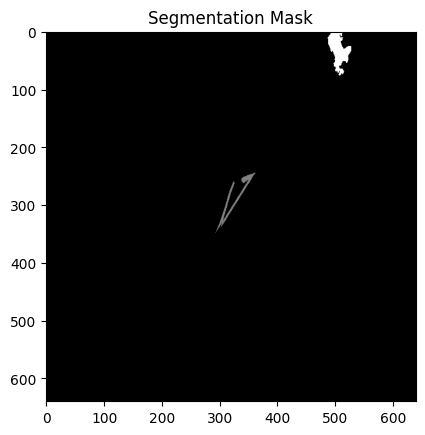

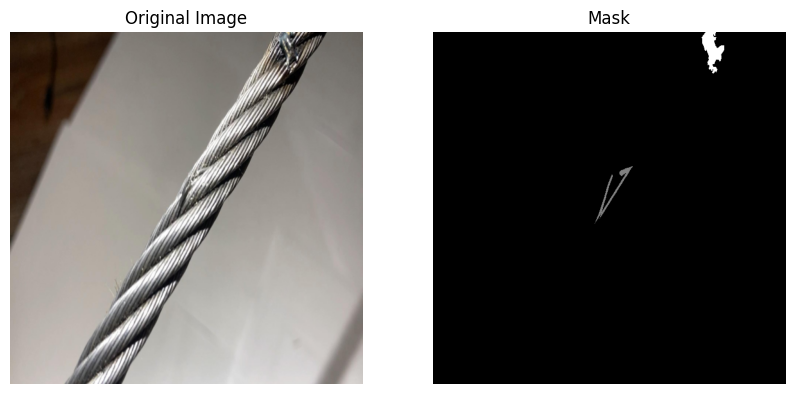

[{'iscrowd': 0, 'image_id': 1014, 'bbox': [29, 325, 16, 20], 'segmentation': [[40, 325, 38, 327, 34, 327, 33, 326, 32, 326, 29, 329, 29, 335, 31, 337, 33, 337, 33, 336, 34, 335, 35, 336, 38, 336, 39, 337, 35, 341, 35, 343, 37, 345, 39, 345, 44, 340, 44, 338, 45, 337, 45, 334, 44, 333, 44, 332, 45, 331, 45, 327, 43, 325]], 'category_id': 2, 'id': 2146, 'area': 209}]
2


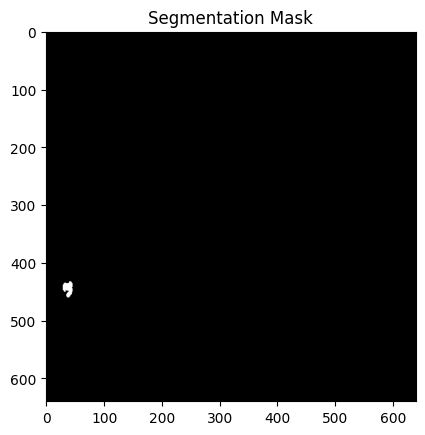

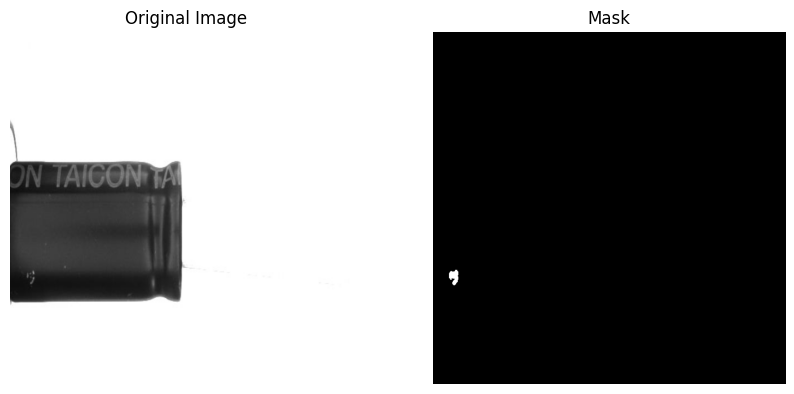

[{'iscrowd': 0, 'image_id': 1019, 'bbox': [140, 86, 25, 13], 'segmentation': [[153, 86, 151, 88, 150, 88, 149, 89, 148, 89, 146, 91, 142, 91, 140, 93, 140, 94, 141, 94, 142, 95, 143, 95, 145, 97, 149, 97, 151, 99, 157, 99, 158, 98, 159, 98, 161, 96, 162, 96, 164, 94, 164, 93, 165, 92, 165, 89, 162, 86, 158, 86, 157, 87, 156, 87, 155, 86]], 'category_id': 2, 'id': 2151, 'area': 216}]
2


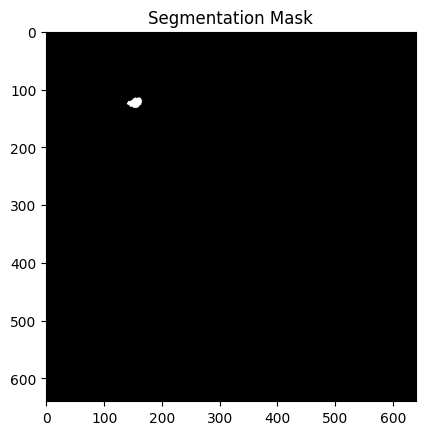

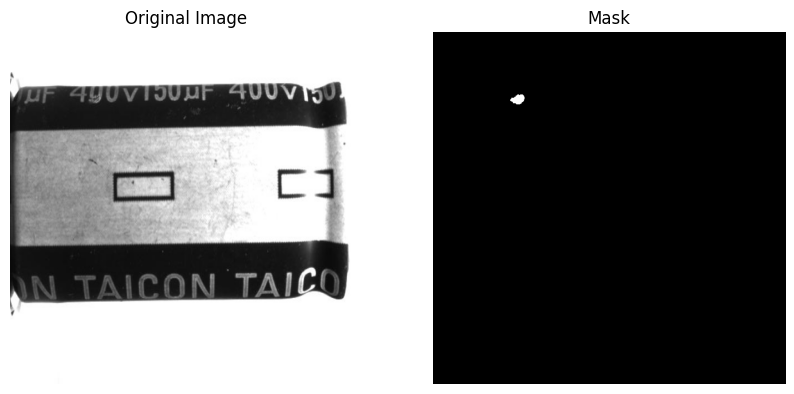

[{'iscrowd': 0, 'image_id': 1022, 'bbox': [314, 71, 24, 21], 'segmentation': [[320, 71, 319, 72, 318, 72, 317, 73, 317, 74, 316, 75, 316, 76, 315, 77, 315, 80, 314, 81, 314, 82, 319, 87, 319, 88, 321, 90, 322, 90, 323, 91, 327, 91, 328, 92, 333, 92, 335, 90, 336, 90, 338, 88, 338, 83, 337, 82, 337, 79, 335, 77, 334, 77, 332, 75, 327, 75, 326, 74, 325, 74, 324, 73, 324, 72, 323, 71]], 'category_id': 2, 'id': 2154, 'area': 350}]
2


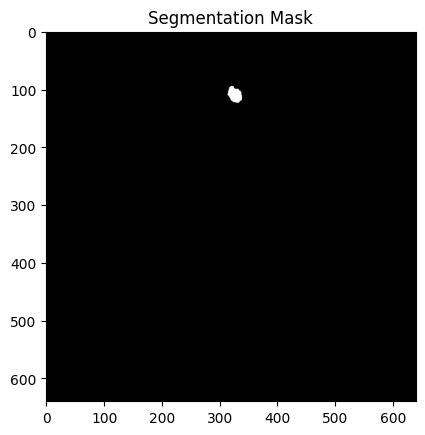

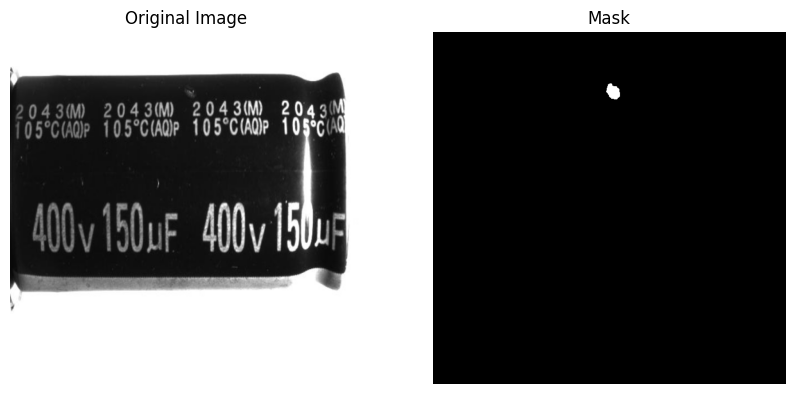

[{'iscrowd': 0, 'image_id': 1025, 'bbox': [243, 196, 10, 12], 'segmentation': [[247, 196, 243, 200, 243, 204, 244, 205, 244, 206, 245, 207, 247, 207, 248, 208, 249, 208, 250, 207, 251, 207, 252, 206, 252, 205, 253, 204, 253, 200, 252, 199, 252, 198, 250, 196]], 'category_id': 2, 'id': 2157, 'area': 92}]
2


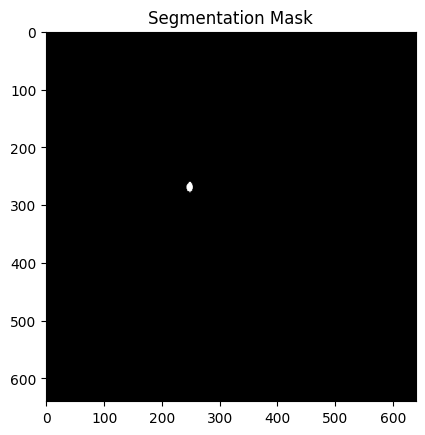

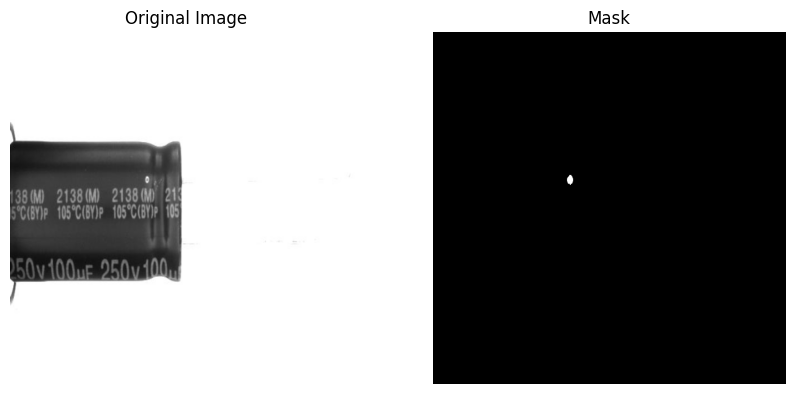

[{'iscrowd': 0, 'image_id': 1027, 'bbox': [121, 274, 48, 38], 'segmentation': [[160, 274, 159, 275, 157, 275, 151, 281, 151, 282, 150, 283, 149, 283, 145, 287, 144, 287, 143, 288, 142, 288, 138, 284, 135, 284, 134, 285, 134, 289, 135, 290, 135, 291, 136, 292, 136, 293, 135, 294, 133, 292, 129, 292, 124, 297, 124, 298, 122, 300, 122, 305, 121, 306, 121, 308, 124, 311, 125, 311, 126, 312, 137, 312, 138, 311, 138, 308, 140, 306, 141, 306, 142, 307, 142, 311, 143, 312, 144, 312, 146, 310, 146, 301, 147, 300, 151, 300, 153, 298, 153, 297, 150, 294, 149, 294, 148, 293, 150, 291, 151, 291, 152, 290, 153, 290, 154, 289, 155, 289, 156, 288, 158, 288, 159, 287, 160, 288, 161, 287, 162, 288, 162, 287, 163, 286, 166, 286, 169, 283, 169, 278, 168, 277, 168, 276, 166, 274]], 'category_id': 2, 'id': 2159, 'area': 782}]
2


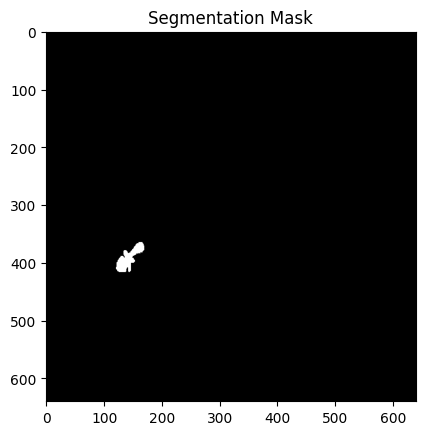

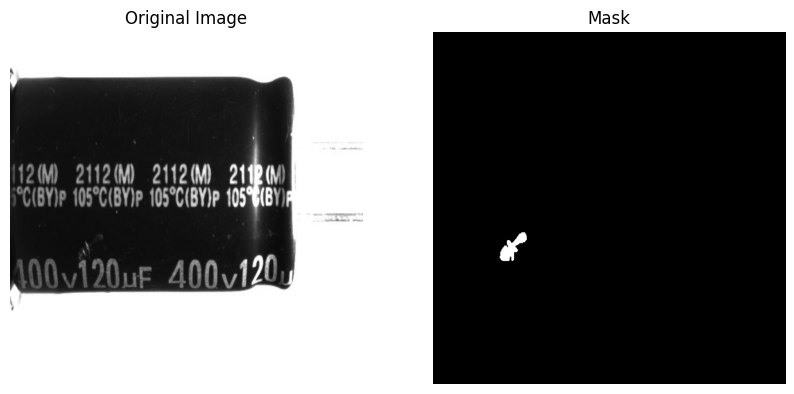

[{'iscrowd': 0, 'image_id': 104, 'bbox': [847, 622, 45, 43], 'segmentation': [[851, 622, 850, 623, 850, 624, 849, 625, 849, 626, 851, 628, 851, 629, 852, 630, 852, 631, 854, 633, 854, 634, 855, 635, 856, 635, 857, 636, 859, 636, 861, 638, 859, 640, 859, 641, 856, 644, 856, 645, 855, 646, 855, 650, 854, 651, 854, 653, 850, 657, 850, 658, 848, 660, 848, 661, 847, 662, 847, 663, 848, 663, 850, 665, 857, 665, 859, 663, 861, 663, 862, 662, 863, 662, 865, 660, 865, 656, 866, 655, 866, 652, 870, 648, 873, 648, 875, 650, 881, 650, 882, 649, 882, 648, 881, 647, 882, 646, 883, 646, 884, 647, 884, 648, 885, 649, 886, 649, 889, 646, 889, 645, 890, 644, 890, 643, 891, 642, 891, 640, 892, 639, 892, 638, 890, 636, 890, 635, 889, 634, 889, 633, 888, 632, 888, 631, 885, 628, 884, 628, 883, 627, 881, 627, 880, 626, 877, 626, 876, 627, 874, 627, 873, 628, 871, 628, 868, 631, 867, 631, 866, 632, 865, 632, 862, 629, 862, 628, 859, 625, 856, 625, 854, 623, 853, 623, 852, 622]], 'category_id': 4, 'id': 132, 

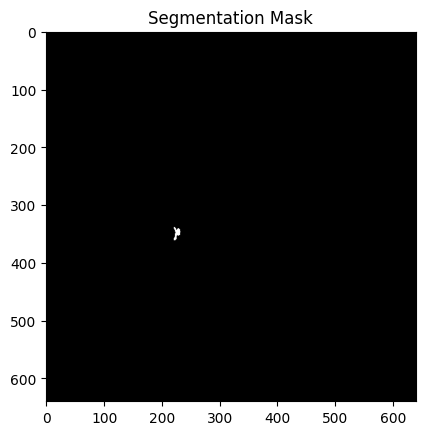

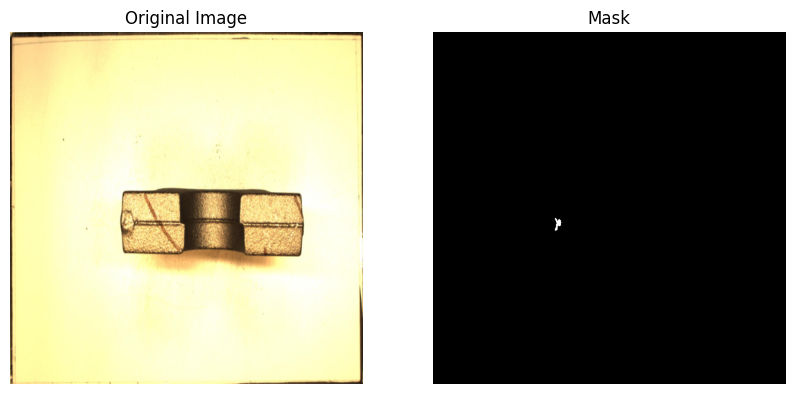

[{'iscrowd': 0, 'image_id': 1040, 'bbox': [260, 67, 32, 21], 'segmentation': [[272, 67, 271, 68, 270, 68, 269, 69, 269, 71, 267, 73, 267, 76, 268, 77, 268, 82, 266, 84, 263, 84, 262, 85, 261, 85, 260, 86, 260, 87, 261, 88, 270, 88, 272, 86, 272, 78, 271, 77, 271, 76, 272, 75, 272, 74, 273, 73, 273, 72, 274, 71, 275, 71, 276, 72, 278, 72, 279, 73, 280, 73, 282, 75, 283, 75, 285, 77, 287, 77, 288, 78, 290, 78, 292, 76, 292, 75, 291, 74, 291, 72, 290, 71, 290, 70, 289, 69, 289, 68, 288, 67]], 'category_id': 2, 'id': 2172, 'area': 245}]
2


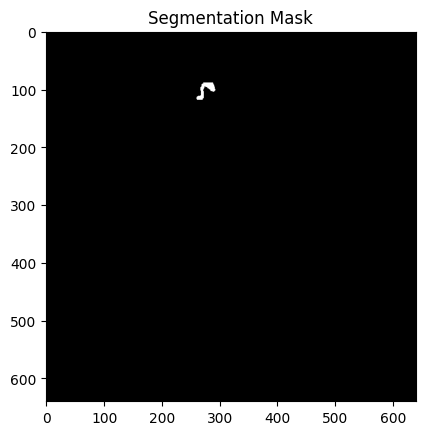

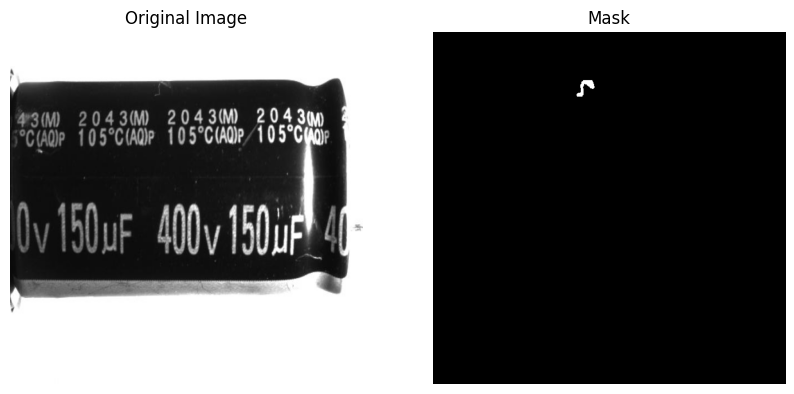

In [29]:
for i in range(10):  # Hiển thị 3 mẫu
    img, mask = dataset[i]  # Lấy mẫu thứ i từ tập dữ liệu
    visualize_sample(img, mask)  # Hiển thị mẫu

In [30]:
def visualize_sample(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img.permute(1, 2, 0))  # Chuyển channel về cuối để phù hợp với yêu cầu của matplotlib
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Tắt các trục

    ax[1].imshow(mask, cmap='gray')  # Hiển thị mask
    ax[1].set_title('Mask')
    ax[1].axis('off')  # Tắt các trục

    
    plt.show()

# Giả sử bạn đã khởi tạo tập dữ liệu và DataLoader của bạn
root_dir = '/kaggle/input/dataset-new/data'  # Thay đổi theo đường dẫn thực tế của bạn
dataset = VISIONDataset(root_dir=root_dir, split='val')


[{'iscrowd': 0, 'image_id': 1, 'bbox': [895, 533, 109, 89], 'segmentation': [[944, 622, 908, 622, 904, 618, 897, 610, 895, 566, 921, 560, 935, 552, 951, 534, 975, 533, 980, 536, 988, 536, 985, 542, 974, 542, 969, 544, 960, 542, 970, 548, 989, 548, 989, 556, 998, 560, 1004, 574, 1000, 591, 992, 598, 969, 600, 952, 618]], 'category_id': 1, 'id': 1, 'area': 6542}, {'iscrowd': 0, 'image_id': 1, 'bbox': [1237, 341, 76, 60], 'segmentation': [[1298, 391, 1289, 391, 1274, 384, 1265, 373, 1262, 361, 1273, 342, 1287, 341, 1298, 350, 1307, 349, 1304, 356, 1313, 364, 1303, 387], [1257, 382, 1244, 378, 1238, 383, 1237, 391, 1243, 392, 1248, 392, 1249, 397, 1254, 401, 1258, 398, 1260, 391, 1258, 386]], 'category_id': 1, 'id': 2, 'area': 2077}]
1
1


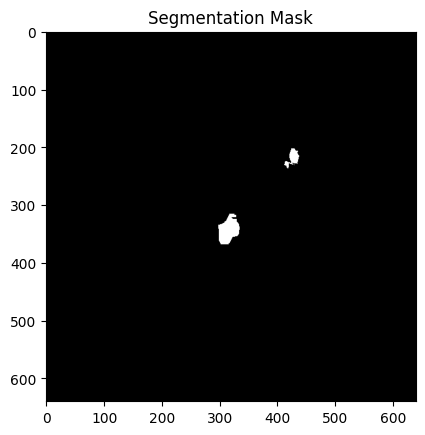

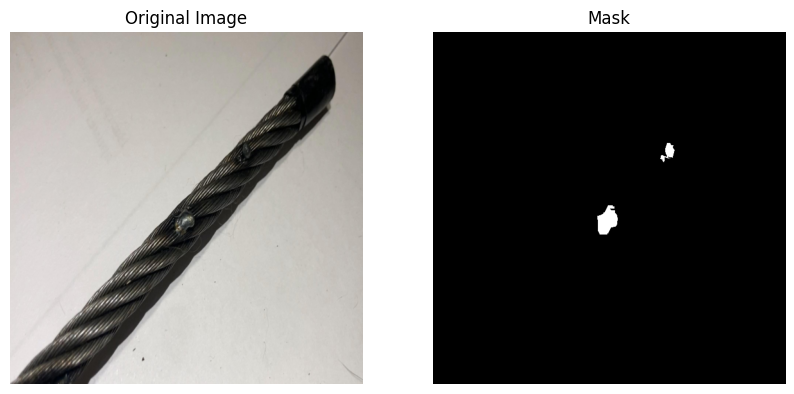

[{'iscrowd': 0, 'image_id': 1001, 'bbox': [0, 222, 304, 80], 'segmentation': [[255, 245, 235, 240, 188, 237, 146, 233, 99, 228, 65, 224, 51, 222, 32, 231, 50, 241, 64, 248, 137, 255, 202, 260, 251, 261, 304, 259], [44, 302, 27, 298, 0, 288, 0, 266, 14, 268, 26, 271, 37, 276, 42, 274, 49, 284, 57, 288, 54, 295]], 'category_id': 0, 'id': 2129, 'area': 6366}]
0


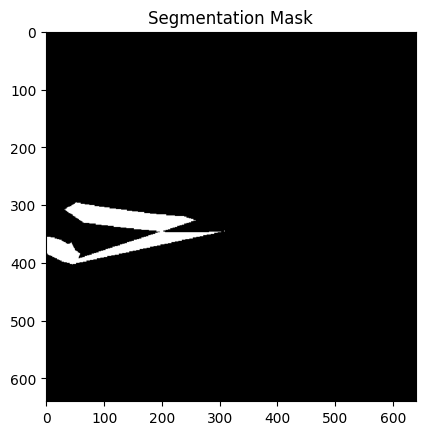

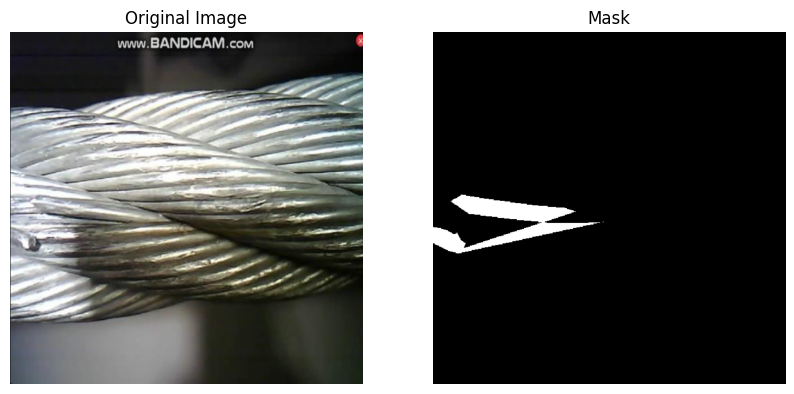

[{'iscrowd': 0, 'image_id': 102, 'bbox': [922, 552, 31, 20], 'segmentation': [[927, 552, 926, 553, 925, 553, 922, 556, 922, 562, 923, 563, 923, 565, 925, 567, 926, 567, 927, 568, 930, 568, 932, 570, 932, 571, 933, 572, 938, 572, 939, 571, 941, 571, 942, 570, 944, 572, 950, 572, 951, 571, 951, 569, 949, 567, 952, 564, 952, 563, 953, 562, 953, 560, 952, 559, 952, 558, 951, 557, 951, 556, 948, 553, 944, 553, 943, 552]], 'category_id': 3, 'id': 129, 'area': 509}, {'iscrowd': 0, 'image_id': 102, 'bbox': [1323, 471, 46, 35], 'segmentation': [[1353, 471, 1352, 472, 1350, 472, 1349, 473, 1347, 473, 1346, 474, 1344, 474, 1343, 475, 1342, 475, 1341, 476, 1340, 476, 1339, 477, 1339, 478, 1337, 480, 1330, 480, 1329, 481, 1327, 481, 1326, 482, 1325, 482, 1324, 483, 1324, 484, 1323, 485, 1323, 487, 1327, 491, 1328, 491, 1329, 492, 1332, 492, 1333, 493, 1333, 498, 1334, 499, 1334, 500, 1335, 501, 1335, 502, 1337, 504, 1338, 504, 1339, 505, 1340, 505, 1341, 506, 1342, 506, 1344, 504, 1344, 500, 1346, 

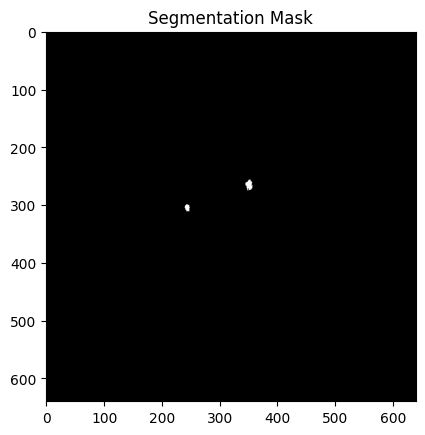

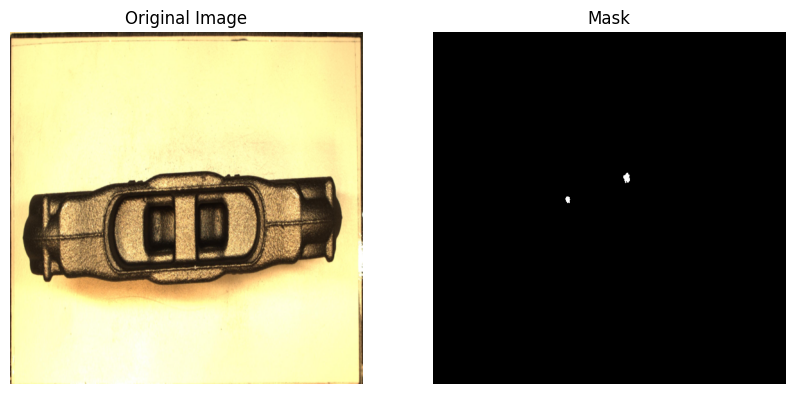

[{'iscrowd': 0, 'image_id': 1029, 'bbox': [75, 79, 44, 26], 'segmentation': [[102, 79, 101, 80, 99, 80, 95, 84, 95, 87, 93, 89, 92, 88, 92, 86, 91, 86, 90, 87, 89, 87, 88, 88, 88, 89, 87, 90, 85, 90, 84, 91, 83, 91, 77, 97, 77, 98, 76, 99, 76, 100, 75, 101, 75, 102, 77, 104, 80, 104, 81, 105, 87, 105, 88, 104, 95, 104, 96, 103, 97, 103, 98, 102, 100, 102, 101, 103, 102, 103, 103, 102, 107, 102, 108, 101, 109, 101, 110, 100, 111, 101, 114, 101, 119, 96, 119, 93, 118, 92, 118, 91, 116, 89, 114, 89, 113, 88, 112, 88, 111, 87, 110, 87, 107, 84, 107, 83, 106, 82, 106, 81, 104, 79]], 'category_id': 2, 'id': 2161, 'area': 661}]
2


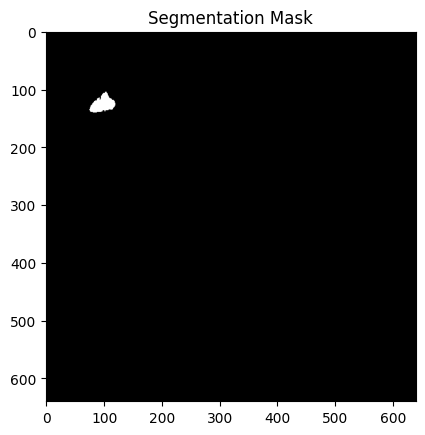

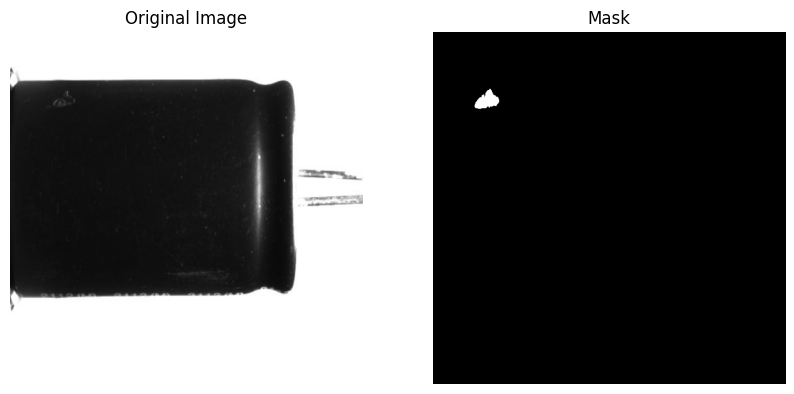

[{'iscrowd': 0, 'image_id': 1035, 'bbox': [598, 143, 14, 26], 'segmentation': [[602, 147, 603, 146, 604, 146, 605, 147, 605, 148, 604, 149], [605, 143, 603, 145, 603, 146, 602, 147, 600, 147, 598, 149, 598, 150, 600, 152, 600, 160, 599, 161, 599, 162, 604, 167, 604, 168, 605, 169, 607, 169, 609, 167, 609, 166, 610, 165, 610, 164, 611, 163, 611, 162, 610, 161, 610, 160, 609, 159, 609, 156, 611, 154, 611, 152, 610, 151, 610, 150, 612, 148, 612, 146, 611, 145, 611, 144, 610, 143, 609, 143, 608, 144, 607, 143]], 'category_id': 2, 'id': 2167, 'area': 247}]
2


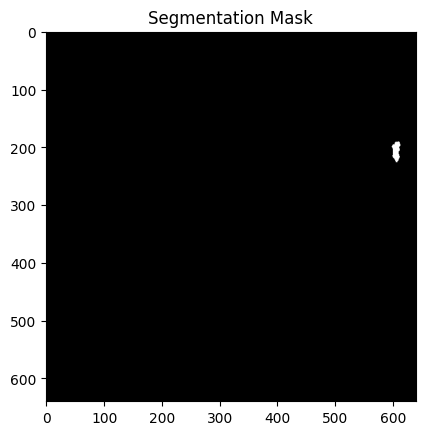

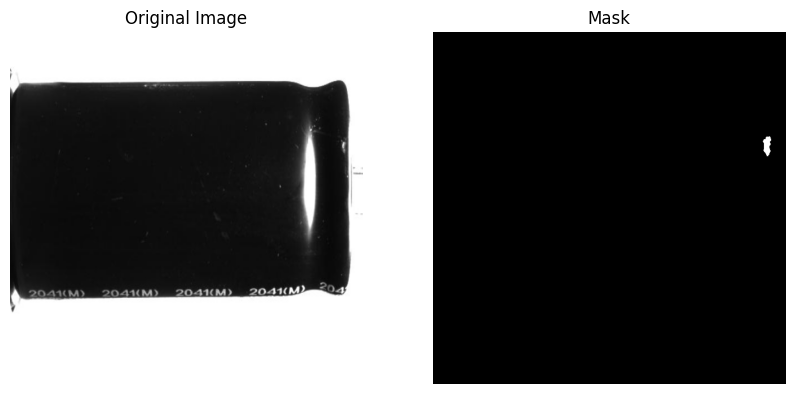

[{'iscrowd': 0, 'image_id': 1036, 'bbox': [249, 239, 17, 16], 'segmentation': [[254, 239, 253, 240, 253, 243, 252, 244, 252, 247, 251, 248, 251, 250, 249, 252, 249, 253, 250, 254, 250, 255, 251, 254, 252, 255, 252, 254, 253, 253, 253, 252, 254, 251, 255, 251, 256, 252, 257, 252, 259, 254, 259, 255, 260, 254, 261, 255, 261, 254, 262, 253, 262, 252, 263, 251, 265, 251, 265, 250, 266, 249, 266, 246, 262, 242, 262, 241, 261, 240, 259, 240, 258, 241, 257, 241, 255, 239]], 'category_id': 2, 'id': 2168, 'area': 164}]
2


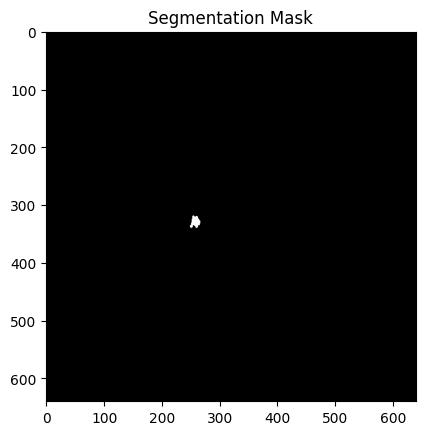

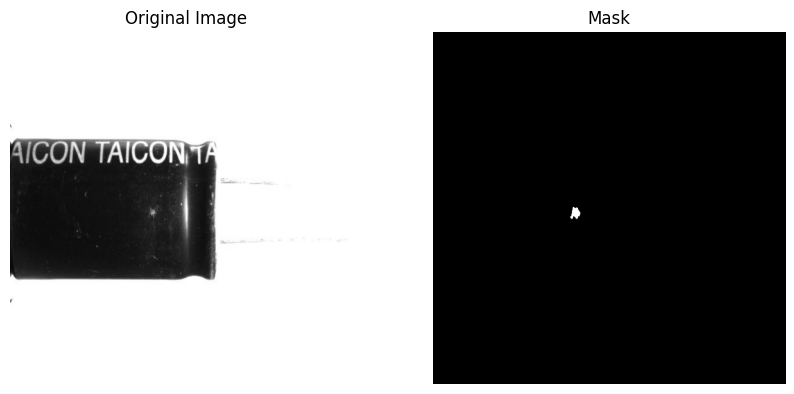

[{'iscrowd': 0, 'image_id': 1045, 'bbox': [126, 68, 41, 16], 'segmentation': [[159, 68, 158, 69, 153, 69, 152, 70, 148, 70, 147, 69, 140, 69, 139, 70, 137, 70, 136, 71, 135, 71, 133, 73, 132, 72, 131, 72, 128, 75, 128, 76, 127, 77, 127, 79, 126, 80, 126, 81, 127, 81, 129, 83, 130, 83, 131, 82, 140, 82, 142, 80, 144, 80, 145, 81, 145, 84, 146, 84, 149, 81, 149, 77, 150, 76, 153, 76, 154, 77, 157, 77, 157, 76, 156, 75, 156, 74, 157, 73, 161, 73, 162, 72, 163, 72, 164, 71, 165, 71, 167, 69, 167, 68]], 'category_id': 2, 'id': 2177, 'area': 336}]
2


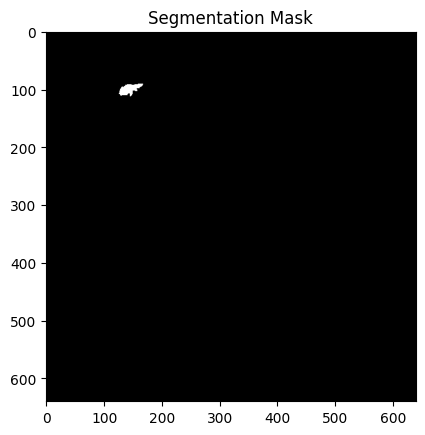

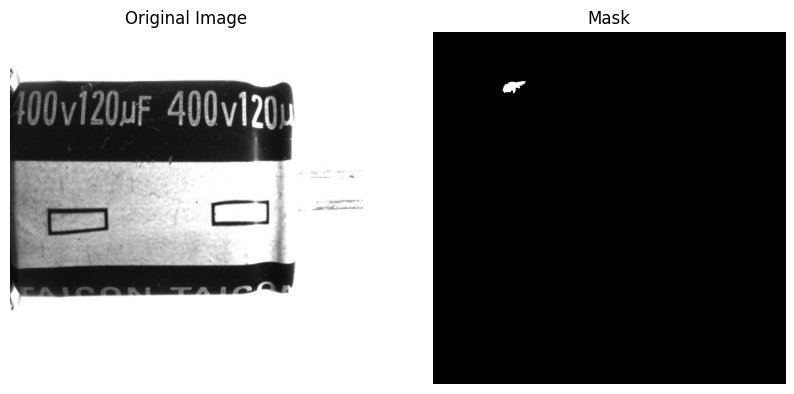

[{'iscrowd': 0, 'image_id': 1108, 'bbox': [3041, 2031, 430, 152], 'segmentation': [[3144, 2031, 3143, 2032, 3141, 2032, 3140, 2033, 3138, 2033, 3137, 2034, 3135, 2034, 3134, 2035, 3132, 2035, 3131, 2036, 3129, 2036, 3128, 2037, 3125, 2037, 3124, 2038, 3122, 2038, 3121, 2039, 3119, 2039, 3118, 2040, 3116, 2040, 3115, 2041, 3113, 2041, 3112, 2042, 3111, 2042, 3102, 2051, 3101, 2051, 3091, 2061, 3091, 2062, 3088, 2065, 3088, 2066, 3086, 2068, 3086, 2069, 3083, 2072, 3083, 2073, 3081, 2075, 3081, 2076, 3078, 2079, 3078, 2080, 3076, 2082, 3076, 2083, 3073, 2086, 3073, 2087, 3071, 2089, 3071, 2090, 3069, 2092, 3069, 2093, 3066, 2096, 3066, 2097, 3064, 2099, 3064, 2100, 3062, 2102, 3062, 2103, 3060, 2105, 3060, 2106, 3057, 2109, 3057, 2110, 3055, 2112, 3055, 2113, 3054, 2114, 3054, 2115, 3053, 2116, 3053, 2118, 3052, 2119, 3052, 2120, 3051, 2121, 3051, 2123, 3050, 2124, 3050, 2126, 3049, 2127, 3049, 2128, 3048, 2129, 3048, 2131, 3047, 2132, 3047, 2134, 3046, 2135, 3046, 2136, 3045, 2137, 3045

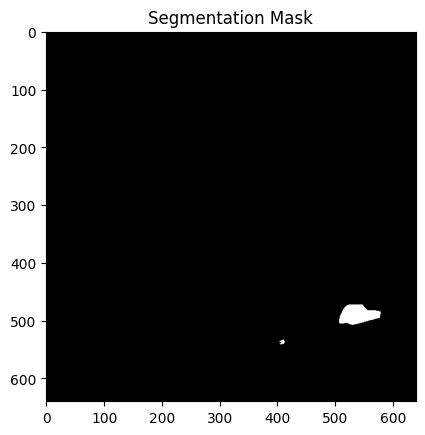

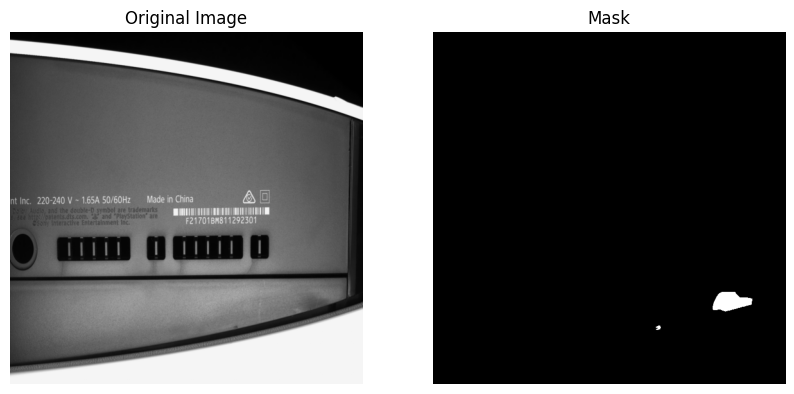

[{'iscrowd': 0, 'image_id': 1133, 'bbox': [2944, 296, 73, 233], 'segmentation': [[3011, 296, 3010, 297, 3007, 297, 3006, 298, 3005, 298, 3004, 299, 3003, 299, 3002, 300, 3001, 300, 2999, 302, 2999, 303, 2998, 304, 2998, 305, 2997, 306, 2997, 307, 2996, 308, 2996, 309, 2995, 310, 2995, 311, 2994, 312, 2994, 313, 2993, 314, 2993, 316, 2992, 317, 2992, 318, 2991, 319, 2991, 320, 2990, 321, 2990, 323, 2989, 324, 2989, 325, 2988, 326, 2988, 329, 2987, 330, 2987, 333, 2986, 334, 2986, 337, 2985, 338, 2985, 341, 2984, 342, 2984, 346, 2983, 347, 2983, 352, 2982, 353, 2982, 378, 2983, 379, 2983, 383, 2982, 384, 2982, 387, 2981, 388, 2981, 390, 2980, 391, 2980, 393, 2979, 394, 2979, 396, 2978, 397, 2978, 398, 2977, 399, 2977, 401, 2976, 402, 2976, 404, 2975, 405, 2975, 408, 2974, 409, 2974, 412, 2973, 413, 2973, 416, 2972, 417, 2972, 420, 2971, 421, 2971, 424, 2970, 425, 2970, 428, 2969, 429, 2969, 434, 2968, 435, 2968, 439, 2967, 440, 2967, 445, 2966, 446, 2966, 451, 2965, 452, 2965, 457, 2964,

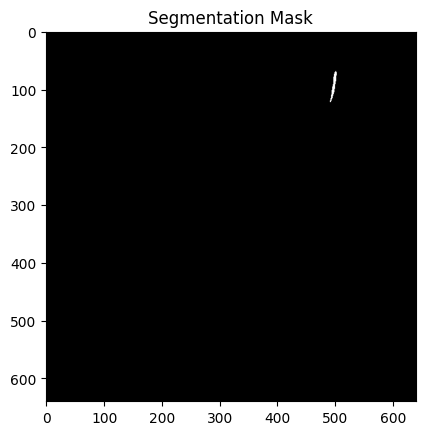

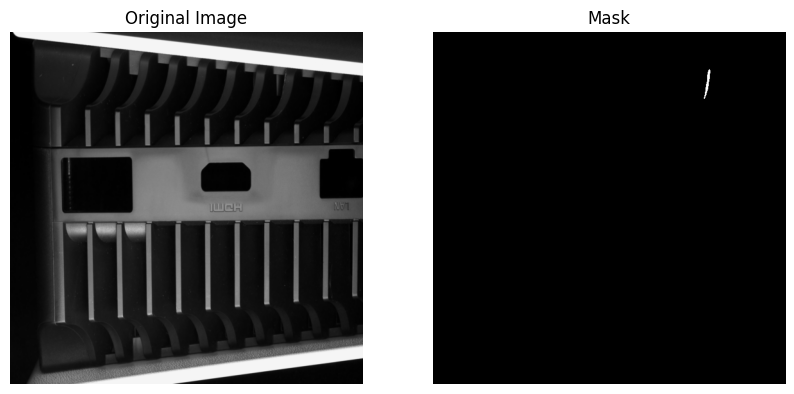

[{'iscrowd': 0, 'image_id': 1167, 'bbox': [158, 326, 35, 14], 'segmentation': [[177, 326, 176, 327, 171, 327, 170, 328, 166, 328, 165, 329, 164, 329, 163, 330, 162, 330, 161, 331, 160, 331, 158, 333, 158, 338, 159, 339, 161, 339, 162, 340, 171, 340, 172, 339, 174, 339, 175, 338, 176, 338, 177, 337, 180, 337, 181, 336, 184, 336, 185, 337, 188, 337, 189, 336, 190, 336, 193, 333, 193, 329, 192, 328, 192, 327, 191, 326]], 'category_id': 8, 'id': 2320, 'area': 364}]
8


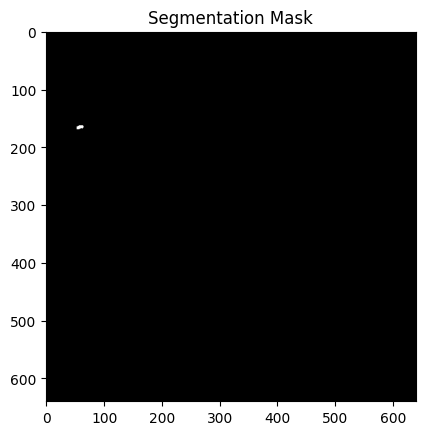

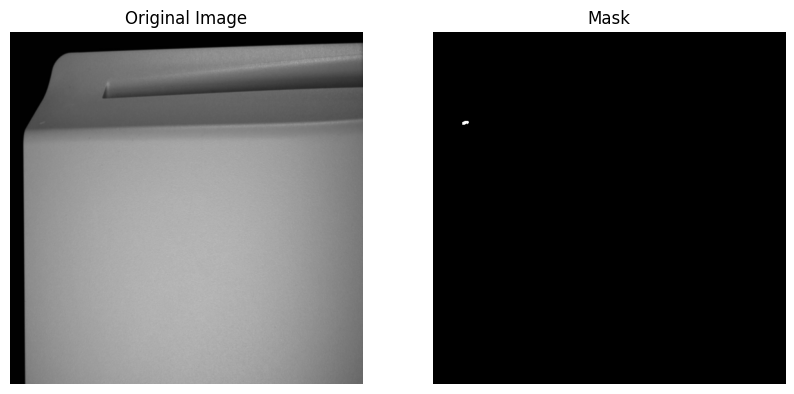

In [31]:
for i in range(10):  # Hiển thị 3 mẫu
    img, mask = dataset[i]  # Lấy mẫu thứ i từ tập dữ liệu
    visualize_sample(img, mask)  # Hiển thị mẫu

In [34]:
def visualize_sample(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img.permute(1, 2, 0))  # Chuyển channel về cuối để phù hợp với yêu cầu của matplotlib
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Tắt các trục

    ax[1].imshow(mask, cmap='gray')  # Hiển thị mask
    ax[1].set_title('Mask')
    ax[1].axis('off')  # Tắt các trục

    
    plt.show()

# Giả sử bạn đã khởi tạo tập dữ liệu và DataLoader của bạn
root_dir = '/kaggle/input/dataset-new/data'  # Thay đổi theo đường dẫn thực tế của bạn
dataset = VISIONDataset(root_dir=root_dir, split='train')


[{'iscrowd': 0, 'image_id': 1000, 'bbox': [1435, 314, 43, 96], 'segmentation': [[1446, 410, 1436, 402, 1442, 389, 1438, 380, 1438, 352, 1435, 340, 1436, 334, 1440, 331, 1438, 320, 1449, 314, 1469, 316, 1478, 324, 1476, 361, 1464, 370, 1454, 405]], 'category_id': 1, 'id': 2128, 'area': 2786}]
1


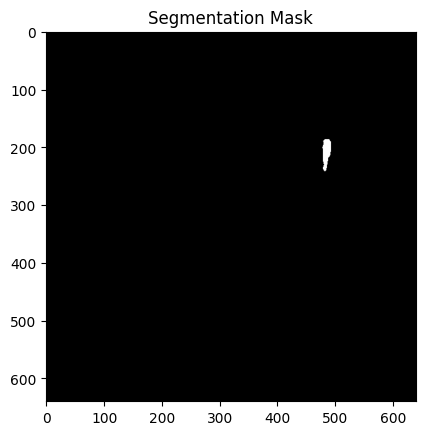

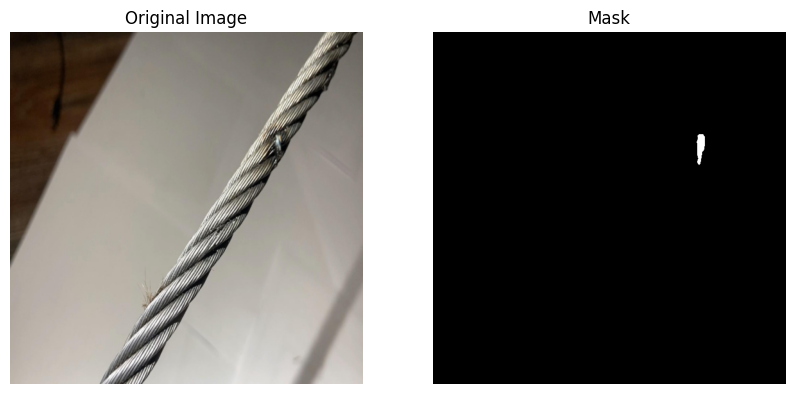

[{'iscrowd': 0, 'image_id': 1003, 'bbox': [261, 240, 87, 60], 'segmentation': [[310, 300, 286, 300, 275, 296, 272, 292, 270, 280, 261, 269, 264, 256, 291, 241, 322, 240, 333, 244, 345, 244, 348, 266, 344, 276, 331, 290]], 'category_id': 1, 'id': 2132, 'area': 4053}]
1


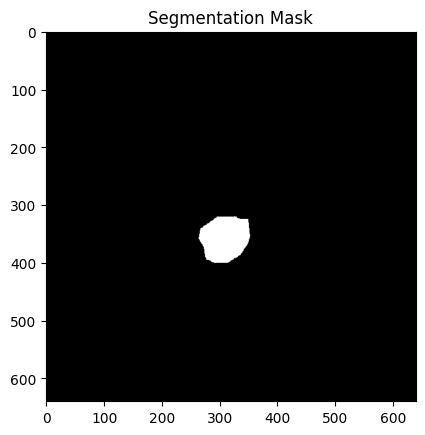

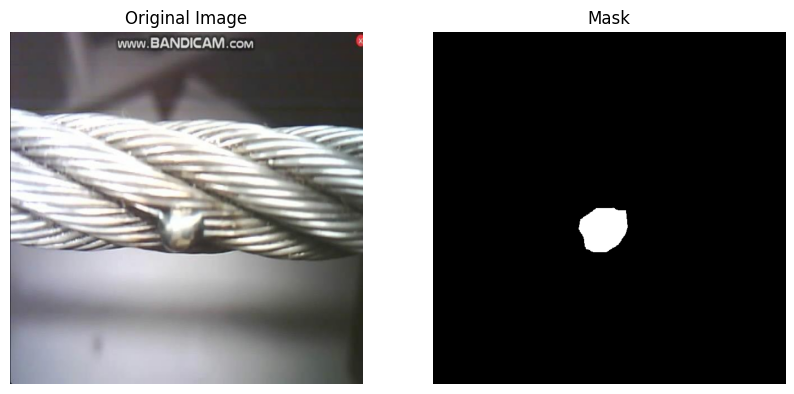

[{'iscrowd': 0, 'image_id': 1004, 'bbox': [0, 202, 219, 15], 'segmentation': [[107, 217, 19, 216, 0, 205, 79, 203, 187, 202, 219, 214]], 'category_id': 0, 'id': 2133, 'area': 2545}, {'iscrowd': 0, 'image_id': 1004, 'bbox': [165, 188, 293, 38], 'segmentation': [[339, 226, 312, 225, 301, 224, 291, 224, 278, 223, 235, 216, 165, 191, 282, 188, 286, 189, 302, 190, 318, 191, 335, 190, 363, 193, 378, 197, 408, 205, 458, 220]], 'category_id': 0, 'id': 2134, 'area': 6738}, {'iscrowd': 0, 'image_id': 1004, 'bbox': [540, 175, 156, 35], 'segmentation': [[696, 194, 696, 210, 656, 208, 620, 204, 540, 177, 607, 176, 667, 175, 696, 175]], 'category_id': 0, 'id': 2135, 'area': 3585}]
0
0
0


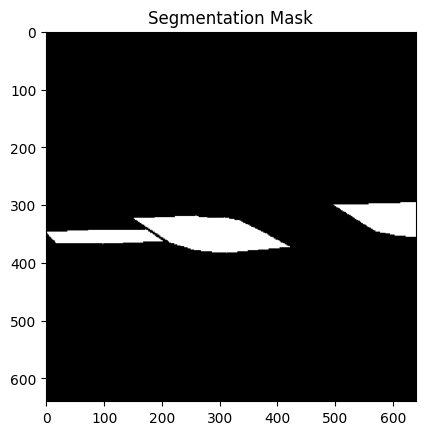

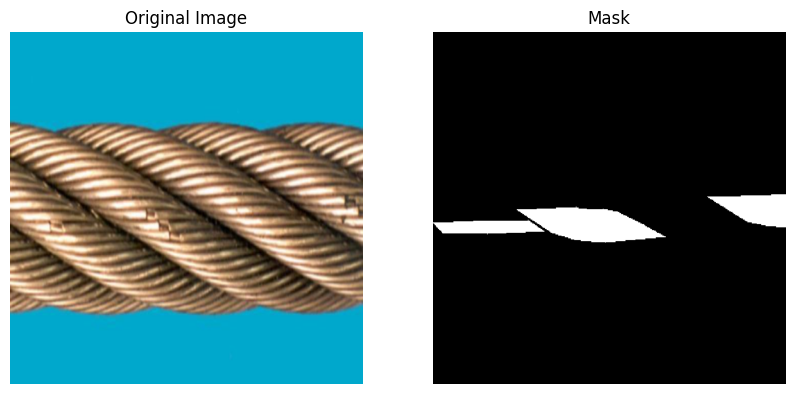

[{'iscrowd': 0, 'image_id': 1005, 'bbox': [928, 677, 98, 123], 'segmentation': [[1001, 800, 980, 791, 965, 771, 963, 771, 959, 783, 951, 778, 943, 787, 928, 746, 930, 706, 961, 682, 975, 677, 983, 678, 985, 681, 982, 701, 978, 709, 967, 719, 954, 719, 950, 727, 959, 736, 966, 734, 977, 728, 987, 714, 995, 738, 998, 725, 1010, 716, 1020, 727, 1024, 739, 1026, 773, 1014, 776, 1008, 790]], 'category_id': 1, 'id': 2136, 'area': 7070}]
1


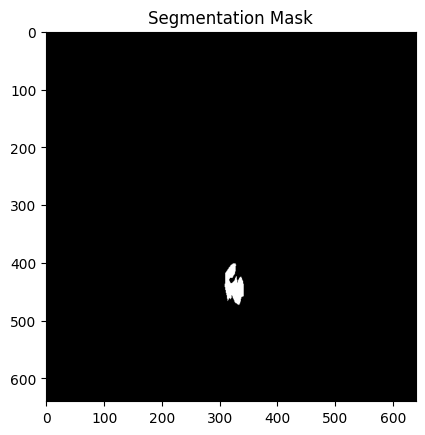

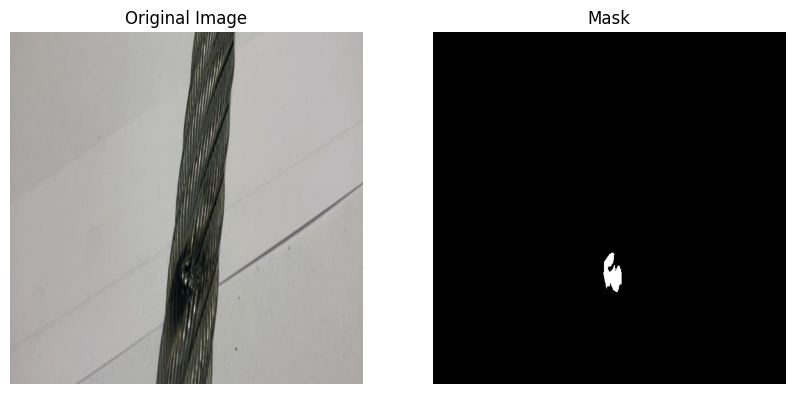

[{'iscrowd': 0, 'image_id': 1006, 'bbox': [628, 448, 138, 126], 'segmentation': [[688, 574, 670, 568, 664, 557, 661, 543, 646, 538, 636, 531, 634, 526, 642, 513, 633, 510, 628, 500, 638, 481, 654, 464, 666, 468, 679, 458, 685, 458, 687, 448, 695, 448, 709, 455, 719, 466, 728, 465, 734, 477, 726, 483, 722, 496, 731, 494, 754, 506, 766, 517, 758, 521, 760, 527, 754, 532, 766, 550, 756, 552, 738, 546, 732, 552, 738, 558, 726, 568, 712, 565]], 'category_id': 1, 'id': 2137, 'area': 10734}]
1


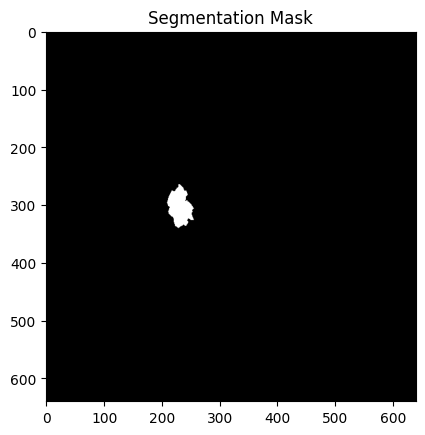

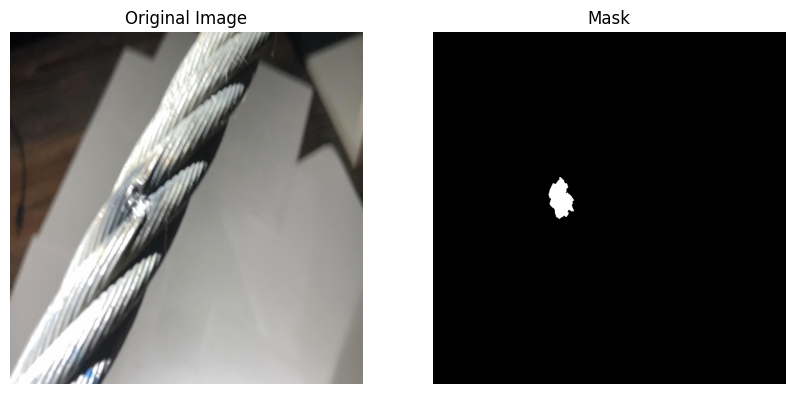

[{'iscrowd': 0, 'image_id': 1007, 'bbox': [1278, 77, 47, 99], 'segmentation': [[1305, 176, 1299, 174, 1292, 161, 1278, 102, 1282, 95, 1297, 84, 1322, 77, 1318, 93, 1325, 119, 1320, 122, 1314, 122, 1318, 152]], 'category_id': 1, 'id': 2138, 'area': 2831}, {'iscrowd': 0, 'image_id': 1007, 'bbox': [860, 423, 164, 151], 'segmentation': [[1020, 423, 1006, 430, 991, 439, 984, 445, 979, 448, 980, 453, 986, 458, 992, 456, 998, 451, 1003, 449, 1014, 438, 1024, 425], [882, 567, 891, 564, 900, 558, 914, 549, 930, 537, 943, 527, 958, 515, 972, 504, 986, 490, 990, 485, 988, 481, 983, 478, 978, 479, 978, 472, 984, 467, 983, 462, 976, 458, 968, 460, 960, 470, 941, 490, 921, 513, 903, 534, 889, 548, 860, 574]], 'category_id': 0, 'id': 2139, 'area': 4046}]
1
0


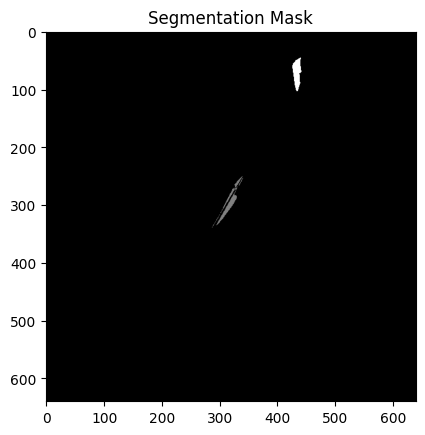

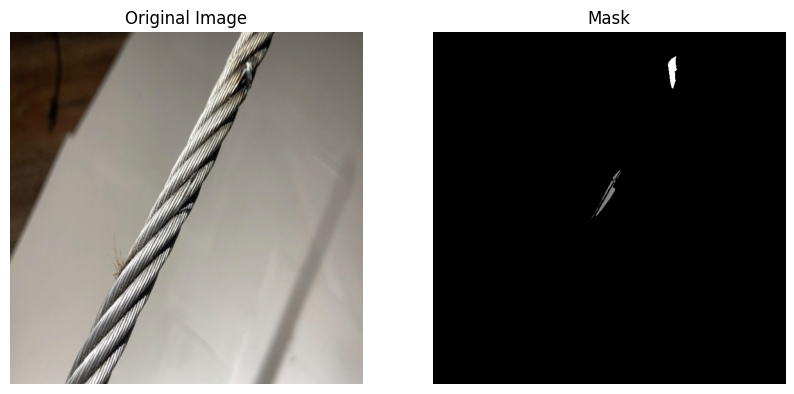

[{'iscrowd': 0, 'image_id': 1008, 'bbox': [98, 286, 415, 66], 'segmentation': [[320, 352, 227, 331, 137, 306, 98, 289, 172, 296, 299, 322, 324, 335, 328, 346], [513, 316, 418, 316, 346, 310, 331, 304, 326, 294, 336, 286, 342, 286, 467, 298, 489, 302]], 'category_id': 0, 'id': 2140, 'area': 7880}]
0


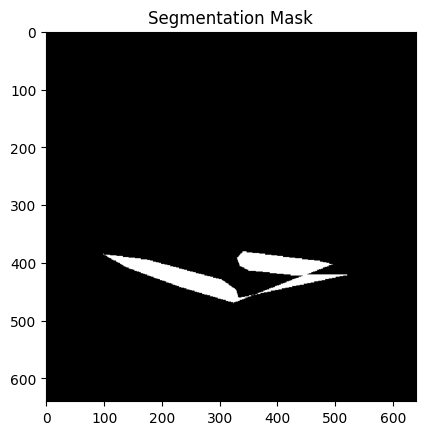

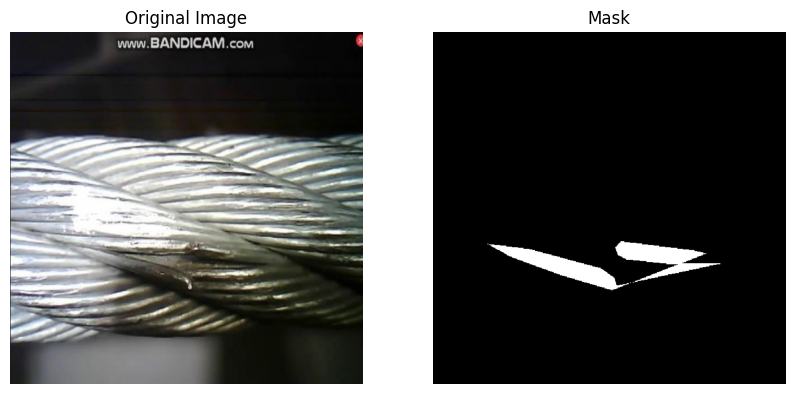

[{'iscrowd': 0, 'image_id': 1009, 'bbox': [1076, 1123, 404, 89], 'segmentation': [[1406, 1182, 1346, 1180, 1334, 1175, 1332, 1160, 1345, 1160, 1361, 1164, 1405, 1178], [1480, 1194, 1469, 1194, 1439, 1184, 1415, 1182, 1414, 1173, 1422, 1164, 1430, 1164, 1471, 1186], [1191, 1212, 1100, 1198, 1081, 1192, 1076, 1186, 1136, 1148, 1181, 1128, 1198, 1135, 1187, 1150, 1152, 1166, 1108, 1194, 1114, 1196, 1172, 1166, 1221, 1148, 1261, 1128, 1281, 1124, 1290, 1128, 1304, 1123, 1312, 1132, 1293, 1150, 1243, 1178]], 'category_id': 0, 'id': 2141, 'area': 11341}]
0


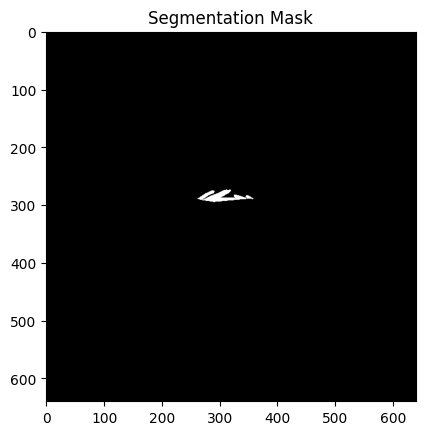

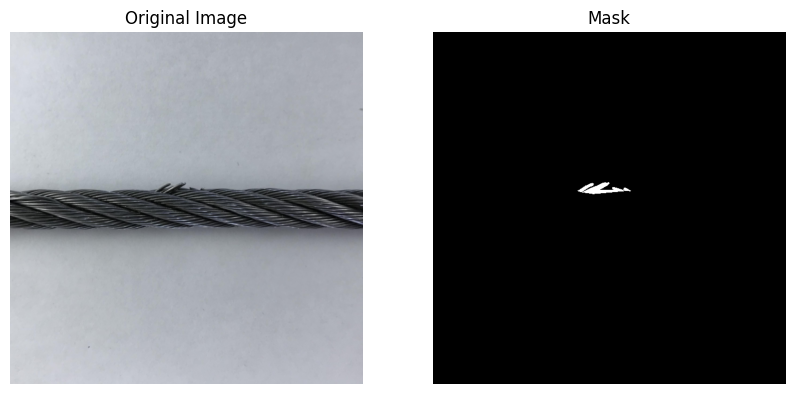

[{'iscrowd': 0, 'image_id': 101, 'bbox': [1944, 576, 53, 92], 'segmentation': [[1951, 647, 1950, 648, 1949, 648, 1946, 651, 1946, 652, 1945, 653, 1945, 655, 1944, 656, 1944, 660, 1948, 664, 1948, 665, 1951, 668, 1953, 668, 1954, 667, 1955, 667, 1956, 666, 1966, 666, 1967, 665, 1968, 665, 1970, 663, 1970, 662, 1972, 660, 1972, 655, 1971, 654, 1971, 653, 1970, 652, 1970, 651, 1969, 650, 1968, 650, 1967, 649, 1963, 649, 1962, 648, 1961, 648, 1960, 647], [1980, 606, 1981, 605, 1982, 606, 1981, 607], [1973, 596, 1975, 596, 1977, 598, 1981, 598, 1983, 600, 1983, 602, 1981, 604, 1981, 605, 1980, 606, 1978, 606, 1977, 607, 1977, 608, 1976, 609, 1976, 610, 1977, 611, 1977, 612, 1976, 613, 1974, 613, 1973, 612, 1973, 611, 1972, 610, 1972, 609, 1971, 608, 1973, 606, 1973, 605, 1972, 604, 1972, 602, 1970, 600, 1970, 599], [1957, 576, 1956, 577, 1957, 578, 1957, 579, 1963, 585, 1963, 586, 1962, 587, 1961, 586, 1958, 586, 1957, 585, 1956, 585, 1954, 583, 1951, 583, 1950, 584, 1950, 586, 1949, 587, 1

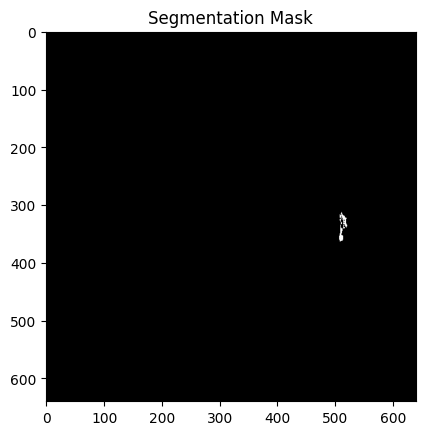

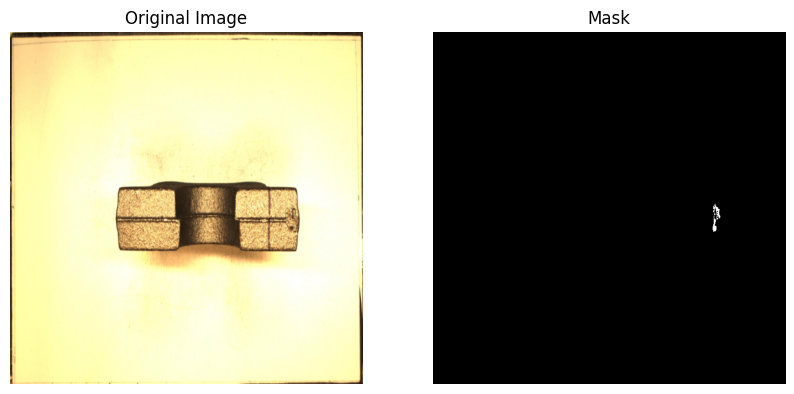

[{'iscrowd': 0, 'image_id': 1010, 'bbox': [94, 252, 323, 80], 'segmentation': [[417, 320, 292, 302, 252, 287, 258, 280, 263, 280, 412, 304, 415, 306], [247, 332, 242, 332, 116, 270, 94, 253, 97, 252, 132, 264, 246, 310, 250, 321]], 'category_id': 0, 'id': 2142, 'area': 5056}]
0


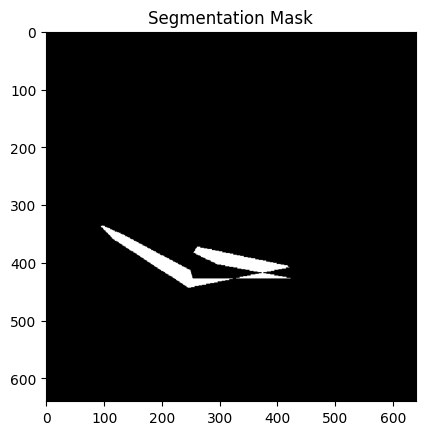

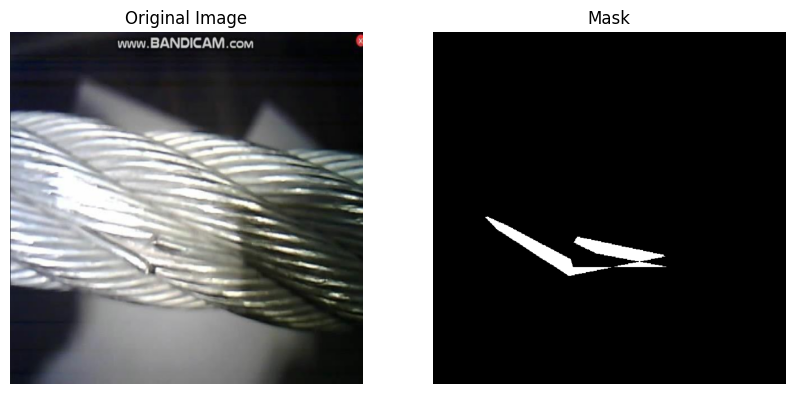

In [35]:
for i in range(10):  # Hiển thị 3 mẫu
    img, mask = dataset[i]  # Lấy mẫu thứ i từ tập dữ liệu
    visualize_sample(img, mask)  # Hiển thị mẫu